# The linear model


*Gries, pp. 149-153, but also pp. 238-243*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({"mathtext.default": "regular", "figure.dpi": 144})
import seaborn as sns
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math

## "Again?"

Linear models are ubiquitous in the sciences and they are used in various corners of data science too. Some of you will already have covered linear models in the Machine Learning course, which will of course be useful. So why do you have to go through this *again*? In Machine Learning, the emphasis is different, because one focuses on:
- the training method, i.e. how do we actually "fit" these models to the observed data?
- the performance, i.e. how well does the method quantitatively perform (esp. on unseen data)?

These are exactly the aspects that are less prominent in a statistical approach to these models. We won't say much, for instance, about how these methods are fitted exactly, and take for granted that they use some kind of common optimization routine internally (typically some kind of "least squares" approach or so). Likewise, evaluating the performance of a model on unseen, **out-of-sample data** also isn't the most common thing to do and papers with a statistical approach will often just report statistics for a single ("training"?) sample. Any machine learner will be able to explain to you why that is a bad idea, i.e. **overfitting**, and it's reassuring to see that the external validation of methods, for instance on a **held-out test set**, is becoming more standard in statistics too.

In statistics, our approach will be more strongly **interpretive** and our primary aim will be to find out what such models can teach us about the data that they are fitted to. Rather than being able to produce a system that can precisely estimate how much connoisseurs will appreciate a new, unseen wine, we want to get an insight into what drove the appreciations of the wines that we already have data on. (Again, this opposition between machine learning and statistics is a **caricature**, because **model criticism** and **model inspection** are common in machine learning too.)

## Regression line

We keep going back to the Arthurian manuscripts case study, because it offers such a clearcut example of a positive correlation, namely for the variables relating to the height and width of the pysical dimensions of the pages and writing surfaces of these books:

In [2]:
df = pd.read_csv("../../datasets/arthur/manuscripts.csv", index_col=0)
df.columns = df.columns.str.replace("-", "_")
dimensions = df[["leaf_height", "leaf_width", "text_height", "text_width"]].dropna()
dimensions

,leaf_height,leaf_width,text_height,text_width
1,308.0,215.0,220.0,164.0
3,280.0,200.0,212.0,163.0
4,230.0,155.0,185.0,132.0
5,232.0,160.0,195.0,127.0
9,260.0,128.0,224.0,128.0
...,...,...,...,...
1155,340.0,230.0,220.0,140.0
1159,334.0,230.0,185.0,290.0
1160,95.0,160.0,250.0,190.0
1163,160.0,140.0,150.0,115.0


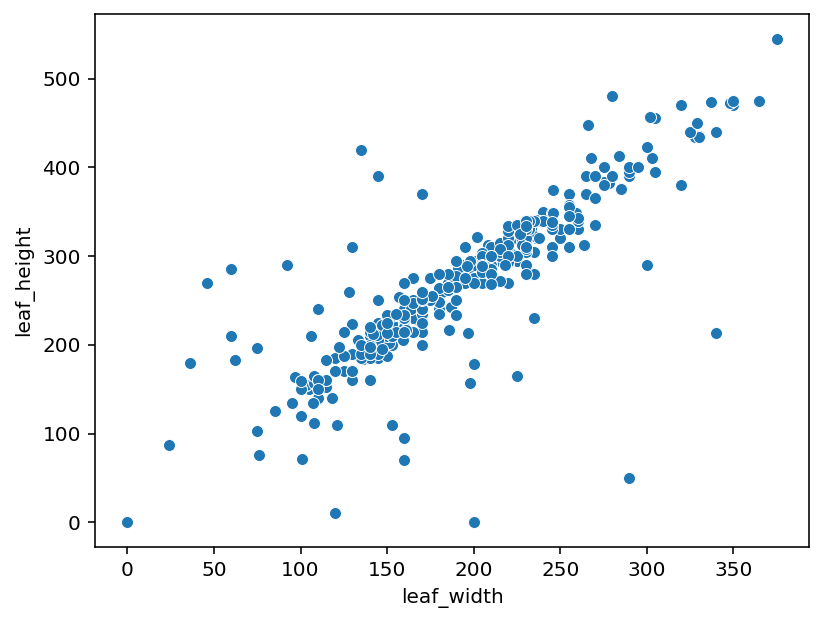

In [3]:
sns.scatterplot(dimensions, y="leaf_height", x="leaf_width")
plt.show()

A **bivariate linear model** is a simple predictive model that aims to model one (numeric) variable as a function of another variable. In our case, we could define a model that aims to predict the height of a book on the basis of its width. The example above shows that such a relationship can sometimes be captured by a **straight line** (hence: "linear"!) that cuts through our sample clouds, minimizing the distance between the points and the actual line. Using a linear model, we can easily calculate what such an optimal **regression line** would like for our sample.

First, let's look at it 'unscientifically' with a seaborn plot

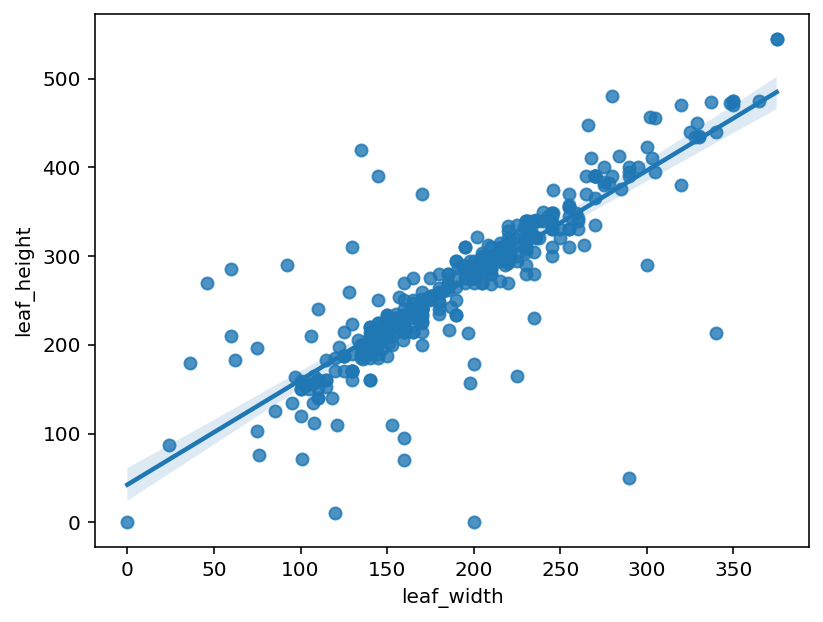

In [4]:
ax = sns.regplot(dimensions, y="leaf_height", x="leaf_width")
plt.show()

# Fitting A Linear Model with 'Ordinary Least Squares' Regression (OLS)

Unfortunately, `seaborn` is good for quick visualisations, but it does not do the kind of formal modelling we will need. For most of the rest of the course we will be relying heavily on a package called `statsmodels`.

Here we will use the **formula API** (`sm.formula.api`) so that we can specify our models using strings. These model strings are almost the same as R (another popular stats package) and so they will hopefully be the easiest for you to learn, and to find examples online. The alternative (`sm.api`) uses "design matrices", which might be more familiar to you if you are doing (or have done) formal machine-learning or linear algebra courses. It's up to you.

In [5]:
model = smf.ols("leaf_height ~ leaf_width", data=dimensions).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            leaf_height   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     1064.
Date:                Sun, 24 Nov 2024   Prob (F-statistic):          9.09e-115
Time:                        10:11:43   Log-Likelihood:                -2094.4
No. Observations:                 402   AIC:                             4193.
Df Residuals:                     400   BIC:                             4201.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     42.5137      7.303      5.822      0.0

Well. That's a lot of stuff. Later on we will deal with some of it (definitely not all of it), but for now we will focus on the "linear" part of "linear regression". The most important thing for now are the model parameters, which are an "Intercept" and a value somehow associated with "leaf_width".

 These are precisely the parameters that we need to be able to draw the **regression line** that was mentioned above. That is because our regression line will be associated with the formula: 

$y = mx + c$

Where $m$ is the **slope** and $c$ is the **constant** (and so at $x=0$ this will be where it meets the y-axis, hence the name `Intercept`)

In [6]:
model.params

Intercept     42.513673
leaf_width     1.179292
dtype: float64

Now we will re-draw the seaborn plot from above, and add a 'raw' straight line with the matplotlib method `ax.axline()` using the parameters we just calculated. As you can see, the lines are the same.

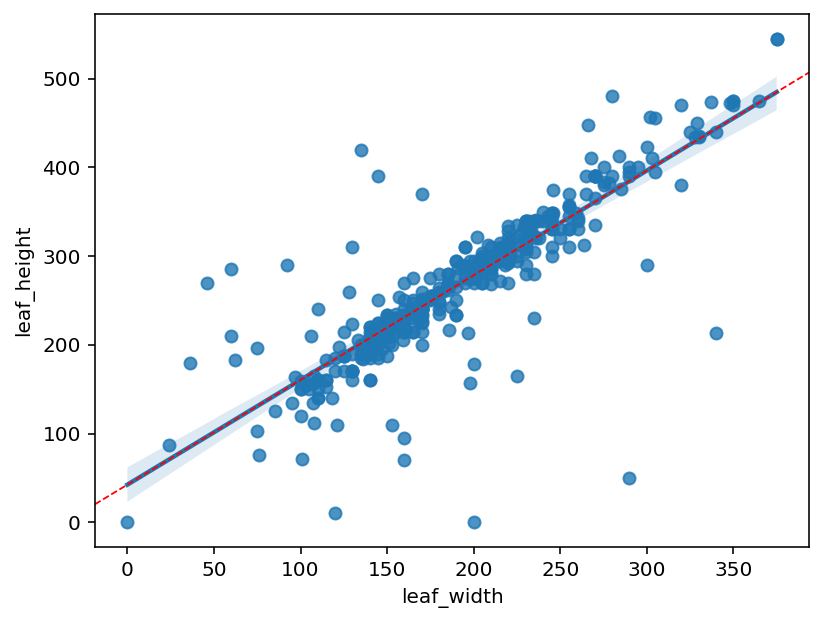

In [7]:
ax = sns.regplot(
    dimensions,
    y="leaf_height",
    x="leaf_width",
    # line_kws={"linewidth": 8, "linestyle": "--", "color": "orange"},
)
ax.axline(
    (0, model.params.Intercept),  # any (x,y) point on the line
    slope=model.params.leaf_width,  # slope, or any second point
    color="red",
    linestyle="--",
    linewidth=0.9,
)
plt.show()

Have a look at the steps which we have followed so far: we store the result of `ols().fit()` inside `model` and use this variable inside a call to `axline()`, which is used for plotting straight lines (onto the `Axis` object that we previously created with `regplot()`). As you can see, the regression line gives us a nice "summary" of the relationship between those variables.

What do the fitted parameters mean?
- The `Intercept` (also "bias" or "offset") is the easiest to understand: in our case, it tells us which "height" a book would have, if it has a minimal "width", i.e. of zero. It makes sense, for this data at least, that the corresponding height should be relatively small. Ideally, it would be **zero**, but that's the theoretical case: note that our actual offset expects a book to be at least ~42 milimeters high.
- The coefficient for the dependent variable (in this case `leaf_height`) tells you how much taller a book becomes for every unit increase in width. Our variables are expressed in milimeters: the coefficient therefore reveals that as a book gets 1 millimeter wider, it will grow about ~1.179 milimeters in height. This coefficient is above 1 and that also makes sense, since your typical medieval codex height will be larger than its width. (If not, we would expect a coefficient that is lower than 1.)
- Between both of those parameters we have the equation for our *line of best fit* ($y = mx + c$, which in this case is $y = 1.179x + 42.5$)

> Note such straightforward interpretations are only possible for data that hasn't been scaled. With $z$-scores, for instance, it becomes much harder to interpret the model's output.

Once we have fitted such a model, we can also use it to make predictions. Suppose, for instance, that we have two books in the dataset that have a width of 303 and 115 milimeters respectively, but for which the height hasn't been recorded (Maybe, all that remains of the books are fragments of the top part of a folio, so that the height couldn't be properly measured?) Could we use our model to "predict" their expected height? Sure, we can:

In [8]:
new_vals = [303, 115]
preds = model.predict({"leaf_width": new_vals})
for v, p in zip(new_vals, preds):
    print(f"Width: {v} -> Predicted Height: {p:.2f}")

Width: 303 -> Predicted Height: 399.84
Width: 115 -> Predicted Height: 178.13


*But* we can also do better! Those numbers are the *mean* estimates. We can also see the 95% confidence intervals by using a different method (with a slightly clunky API, but that is how things go sometimes):

In [9]:
model.get_prediction({"leaf_width": new_vals}).summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,399.839118,4.567663,390.859493,408.818742,312.059334,487.618901
1,178.132241,3.571603,171.110783,185.153699,90.531114,265.733369


This tells us, for example, that the 95% CI for a width of 303 is $(390.86,408.82)$. In other words the model is 95% confident that the height of a new manuscript would be between those values.

Models like this can be seen (or used) as both **explanatory** (they describe a relationship between variables) and **predictive** (they allow us to interpolate or extrapolate *new points* according to the hypothetical model). Now we will think about how to determine **how well** they do those things.

# Ordinary Least Squares

So how does it work? Ordinary Least Squares uses a fairly complicated set of possible algorithms, but the idea is straightforward. It aims to **minimise the (squared) residuals**. "OK," you ask, "but what's a residual?" The 'residual' for each point is essentially the prediction error -- how far is the *predicted point* from the *actual point*. One reason that we square them is so they are always a non-negative quantity.

The code to draw them is a little complicated (sorry), but here they are! The 'residuals' are these dashed grey lines. If you find the red line that minimises the (absolute) length of all the grey ones, that's your best fit.

> QUESTION: Why do the grey lines go straight up and down? The 'shortest' line connecting the point to the regression line would be at 90 degrees to the red line...?

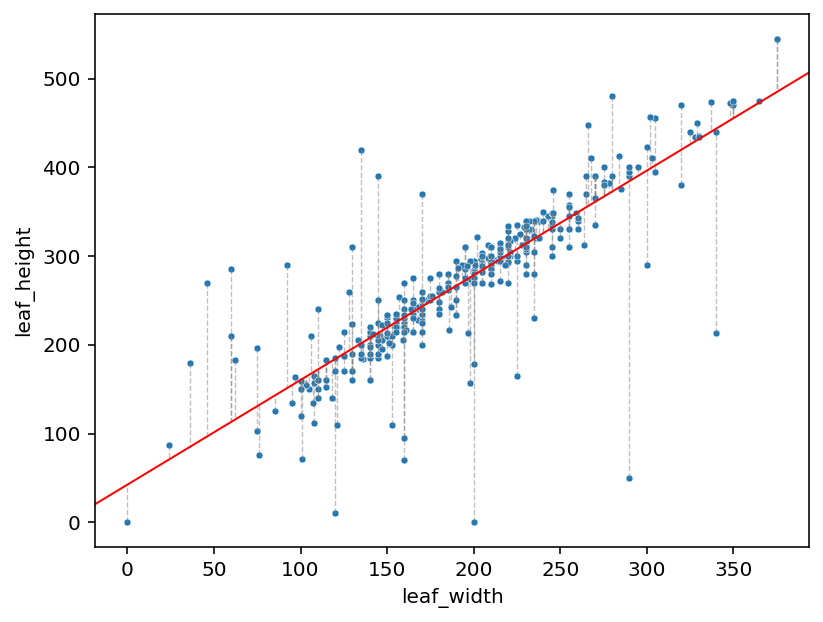

In [10]:
from matplotlib import collections as mc

lines = [
    [(i, j), (i, i * model.params.leaf_width + model.params.Intercept)]
    for i, j in zip(dimensions.leaf_width, dimensions.leaf_height)
]
lc = mc.LineCollection(
    lines, colors="grey", linewidths=0.7, zorder=1, alpha=0.5, linestyle="--"
)
ax = sns.scatterplot(dimensions, y="leaf_height", x="leaf_width", s=12)
ax.axline(
    (0, model.params.Intercept), slope=model.params.leaf_width, color="red", linewidth=1
)
ax.add_collection(lc)
plt.show()

# Evaluating The Model

To get the whole picture for your model, you would typically call `summary()` on it. Interpreting the result (and properly reporting it) is typically the hardest stage of running a linear model:

In [11]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            leaf_height   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     1064.
Date:                Sun, 24 Nov 2024   Prob (F-statistic):          9.09e-115
Time:                        10:11:44   Log-Likelihood:                -2094.4
No. Observations:                 402   AIC:                             4193.
Df Residuals:                     400   BIC:                             4201.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     42.5137      7.303      5.822      0.0

There is a huge amount of information here, which we will break down by sections.

# Top - Model Information and Performance

The most important thing here is the $R^2$. **R-squared** is the **coefficient of determination**: it gives you an idea of the amount of variance in the data that your model can account for, i.e. to which extent it explains the behaviour of the output variable. In the univariate case, it is conceptually very close to the $r$ coefficient of correlation, hence the name. You can obtain the $R^2$, by squaring the (Pearson) correlation coefficient:

In [12]:
sp.stats.pearsonr(dimensions.leaf_height, dimensions.leaf_width).statistic ** 2

0.7268226394634926

We won't cover the exact computation, but intuitively you can think of this number as the percentage of variance that your model explains: the higher it is, the tigther your model was able to fit the data. Thus, the higher it is, the "better". In our case, just the width of a book explained over 72% of the variance in the heights of the book (which is a reasonably high number). For two perfectly correlated variables,  you'd get an $R^2$ of 1 -- but for really bad models it can even be negative.

The next measure that is given, the **adjusted $R^2$**, is the number that is often used to compare fits across different models: this variant accounts for the number of features that your model includes. A model that has access to more variables naturally has a better chance of getting a good fit. (On the other hand, a model with more parameters also has a better chance of *overfitting*.) To provide a fairer comparison, it's preferable to report this "adjusted" version of $R^2$ (and typically this implies a reduction of the score, for models with relatively more explanatory features). For our example, however, the adjustment doesn't change much, since we only had one variable.

Also included here are the **Akaike information criterion** (AIC) and **Bayesian information criterion** (BIC). These are both used to *compare* models, which we will talk about later.

The F statistic and its associated $p$-value really only tell us whether this model is any good overall (is it significantly better than a horizontal line).

> SUMMARY: You should always report the (Adjusted) R-squared, and that is the key thing in this section.

# Middle - Model Parameters

Next up is  the table with the **coefficients**. Remember the model has two parameters: the intercept and the coefficient associated with the independent or "input" variable `leaf_width`, which is the sole **predictor** in our model. For each of these, you get a number of scores:
- the actual estimates (which we already inspected above and used to plot the regression line)
- the standard error on those estimates (so that you get an idea of the stability of this estimates and the "wiggle" around them)
- a 95% confidence interval for the estimate
- a (mysterious) $t$-value
- a $p$-value (accompanied by some reading aids regarding the significance levels, using asterisks)

The row about the intercept is typically not dwelt on for very long, since it depends so strongly on how you preprocessed or normalized the data (whether or not the bias is "significantly different from zero" is typical not a very exciting question). The information for the coefficient printed on the next line is more important. This is telling you whether the coefficient has a significant effect in the model, which is exactly what you want to know!

The $t$-value is a test statistic that measures whether the `Intercept` and named coefficient(s) are 'real'. $H_0$ for both is that the true intercept / variable effect(s) are 0, and the $p$-value is the result of testing the statistic.

> TL;DR: A low $p$-value for a dependent coefficient allows you to reject $H_0$, and conclude that this coefficent has a statistically significant association with the independent variable.

<small> *Side note*: The T statistic here is obtained by just coef / std err, don't worry about it. </small>

# Bottom - Properties of The Residuals

The bottom section gives you a lot of information about the residuals, in particular a lot of tests for their normality, and 'auto-correlation' (we don't want that, but it's out of scope for now). In a perfect world, the residuals would be normally distributed, under the assumption that for a 'good' model most of the points will be close-ish to the line, and neither consistently above or below it.

If your residuals are NOT normally distributed then a lot of the statistical assumptions (standard error, confidence intervals, $p$-values...) will *not be accurate*. This is not the end of the world, but it does mean that you have more work to do. There are many possible causes for a lack of normality:
- Outliers or erroneous data points
- Strongly non-normal distributions in the variables
- It's Just The Wrong Model (tm)

# My Residuals aren't normal. Now what?

Let's check our model!

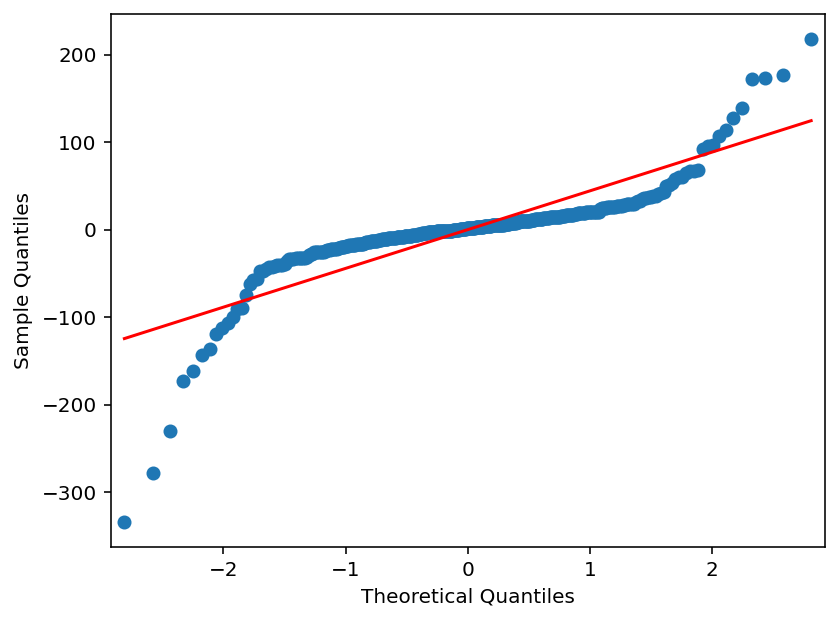

In [13]:
sm.qqplot(model.resid, line="s")
plt.show()

... that seems bad, right? It's always a good idea to just look, and what we see below is that a LOT of points have huge residuals. This means that way too much probability is in the tail of our distribution, which is why it's so not-normal.

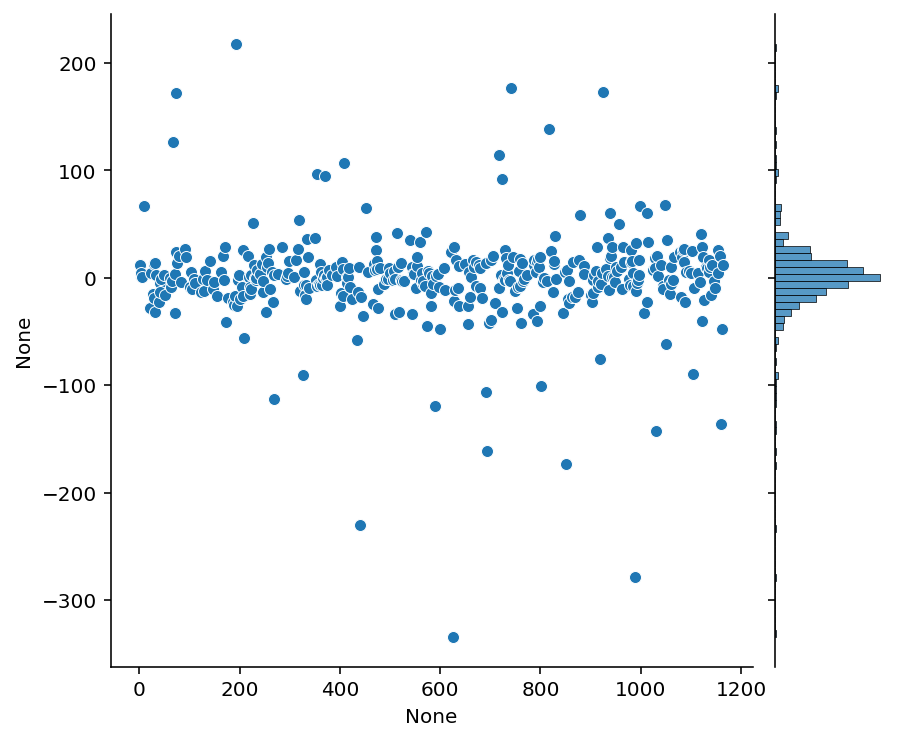

In [14]:
g = sns.jointplot(model.resid)
g.ax_marg_x.remove()

To go further, we will quickly show you how to read an **influence plot**. The is an influence plot built into `statsmodels` and you should use it, but to explain what is happening we will use a fancier interactive version below. You won't be tested on the fancy version.

The basic idea is that we go through every point, and see how the model changes without it. In this way we find out which points **change the model parameters a lot** (this is leverage), and which points **are big residual outliers**. The combined severity of those effects is used to change the point size based on "Cook's Distance" which is beyond the scope of this course.

So, small points that are close to (0,0) (low leverage, low residual error) are the ones that are fitted well. Outliers are the points causing us problems.

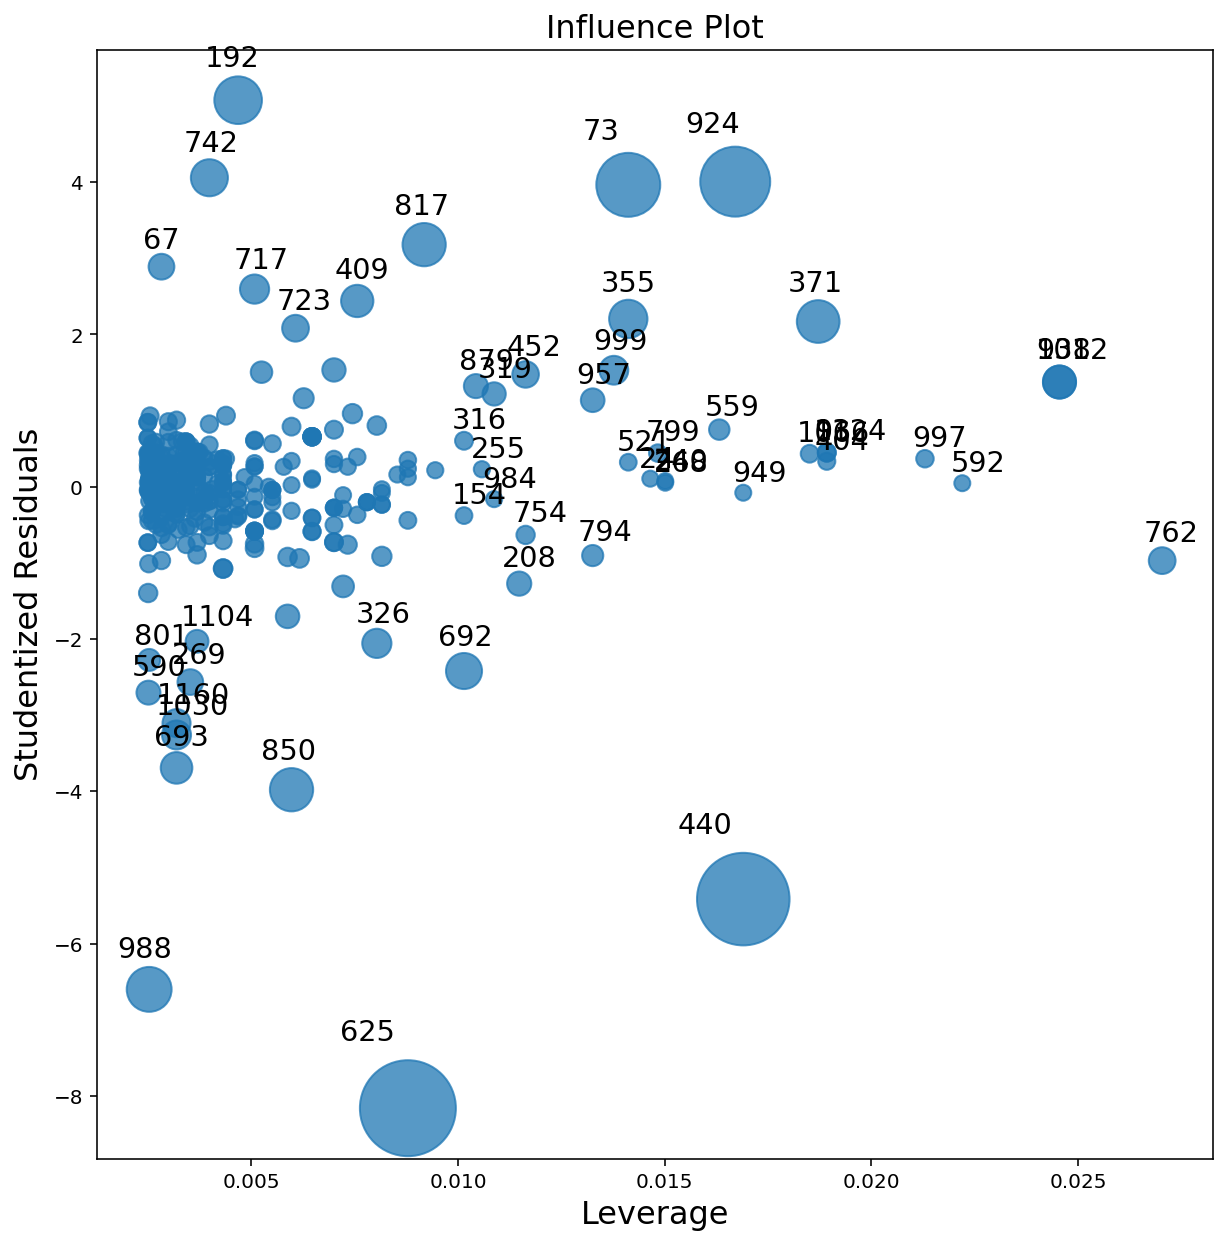

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
sm.graphics.influence_plot(model, fig=fig, ax=ax)
plt.show()

We already discovered (during the homework) that there are quite a few data errors. Below we have provided a little code block to mark points that seem impossible, either because one or more leaf dimension is 0, or because the text dimensions exceed the physical dimensions of the page (as entered)

In [16]:
# %pip install hvplot

In [17]:
from statsmodels.stats.outliers_influence import OLSInfluence
from bokeh.models import HoverTool

# find points that are definitely bad
bad = (
    (dimensions.leaf_height < dimensions.text_height)
    | (dimensions.leaf_width < dimensions.text_width)
    | ((dimensions.leaf_width * dimensions.leaf_height) < 0.01)
)

# pull technical stuff out of the statsmodels internals
infl = OLSInfluence(model).summary_frame()
resid = infl.student_resid
hd = infl.hat_diag
psize = infl.cooks_d

# rescale point sizes based on "point-to-point" (np.ptp) spread that is already in the data
old_range = np.ptp(psize)
new_range = 48**2 - 8**2
psize = (psize - psize.min()) * new_range / old_range + 8**2

df = pd.DataFrame({"Residuals": resid, "Leverage": hd})
# join columns from the dimensions df to the df we're about to plot by index value
df = df.join(dimensions[["leaf_height", "leaf_width", "text_height", "text_width"]])
# Bokeh magic to make the hovertips work
hover = HoverTool(
    tooltips=[
        ("index", "@index"),
        ("leaf_height", "@leaf_height{0.0}"),
        ("leaf_width", "@leaf_width{0.0}"),
        ("text_height", "@text_height{0.0}"),
        ("text_width", "@text_width{0.0}"),
    ]
)

df.plot.scatter(
    x="Leverage",
    y="Residuals",
    size=psize,
    color=np.where(bad, "firebrick", "steelblue"),
    backend="hvplot",  # pandas magic to use a different backend
    hover_cols=["index", "leaf_height", "leaf_width", "text_height", "text_width"],
    tools=[hover],
    width=800,
    height=600,
)

:Scatter   [Leverage]   (Residuals,_color,_size,index,leaf_height,leaf_width,text_height,text_width)

So, we have a lot of bad points which are causing trouble, but also a lot of troublesome points that we have no immediate cause to reject. We can at least drop the definitely bad points and try again....

In [18]:
model2 = smf.ols("leaf_height ~ leaf_width", data=dimensions[~bad]).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:            leaf_height   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     1558.
Date:                Sun, 24 Nov 2024   Prob (F-statistic):          6.01e-136
Time:                        10:11:45   Log-Likelihood:                -1881.6
No. Observations:                 379   AIC:                             3767.
Df Residuals:                     377   BIC:                             3775.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     38.5793      6.295      6.129      0.0

But, sadly, no luck. (Check the normality tests in the bottom section. If you like, run Shapiro-Wilk or a QQ plot to convince yourself.) For now our only choices are to either:
- JUST REPORT IT (this relationship is very obviously linear, we just can't make sound claims about *how* linear)
- Go back to the data and look for errors (welcome to Humanities Data Analysis!)

> Remember. If you have a data problem, you can Just Report It. Nobody can make you withdraw your accepted paper if you Just Report It. You will certainly not regret Just Reporting It.

<a href="https://imgflip.com/i/95qkgc"><img src="https://i.imgflip.com/95qkgc.jpg" title="made at imgflip.com"/></a><div><a href="https://imgflip.com/memegenerator"><small>from Imgflip Meme Generator</small></a></div>

```
Version History

Current: v1.0.1

5/10/24: 1.0.0: first draft, BN
09/10/24: 1.0.1: proofread, MK
```